# RSNA Pneumonia Detection Challenge: Using Mask R-CNN

see: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge

In this competition, you’re challenged to build an algorithm to detect a visual signal for pneumonia in medical images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs.


In [0]:
!pip install tensorflow-gpu==1.14.0
!pip install keras==2.2.5
!pip install git+https://github.com/matterport/Mask_RCNN.git

In [0]:
import os
import random
from collections import defaultdict

import numpy as np
import pandas as pd
from PIL import Image
import pydicom
import matplotlib.pyplot as plt
import cv2
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.config import Config
from mrcnn import utils
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import scipy

DATA_DIR = '/kaggle/input/rsna-pneumonia-detection-challenge'
MODEL_DIR = '/kaggle/model'

## Exploratory Data Analysis

In [0]:
for name in os.listdir(DATA_DIR):
    print(os.path.join(DATA_DIR, name))

/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv
/kaggle/input/rsna-pneumonia-detection-challenge/GCP Credits Request Link - RSNA.txt
/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images
/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_test_images
/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv
/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_sample_submission.csv


原本這個挑戰的名稱是Pneumonia Detection，中文為肺炎偵測，但其實它的Bounding Box所標示的是Lung Opacity的區域，中文為肺部不透光。  

Lung Opacity是一個寬鬆的定義，不透光的成因是因為X光優先在這些區域被吸收，所以看起來會比周圍暗一點，Lung Opacity是個判斷肺炎的指標，也是我們想要判斷的目標。

所以，沒有Lung Opacity也不代表這個肺部是沒有問題的，因此在詳細的資料中你可以看到有三種分類
* Normal
* No Lung Opacity / Not Normal
* Lung Opacity  

如下所示

In [0]:
meta_df_1 = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv'))
meta_df_2 = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_detailed_class_info.csv'))
meta_df = pd.concat([meta_df_1, meta_df_2[['class']]], axis=1)
meta_df

                                  patientId      x      y  width  height  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN   
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN   
2      00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN   
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN   
4      00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0   
...                                     ...    ...    ...    ...     ...   
30222  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8  185.0  298.0  228.0   379.0   
30223  c1edf42b-5958-47ff-a1e7-4f23d99583ba    NaN    NaN    NaN     NaN   
30224  c1f6b555-2eb1-4231-98f6-50a963976431    NaN    NaN    NaN     NaN   
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  393.0  261.0   345.0   
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a  233.0  424.0  201.0   356.0   

       Target                         class  
0           0  No Lung Opacity / Not Norm

建立原始數據的讀取方法

In [0]:
class TrainRawDataLoader:
    def __init__(self, dir, seed=9417):
        self._dir = dir
        meta_df = pd.read_csv(os.path.join(self._dir, 'stage_2_train_labels.csv'))
        meta = {}
        for _, row in meta_df.iterrows():
            patient_id = row.patientId
            if patient_id not in meta:
                meta[patient_id] = {}
                meta[patient_id]['boxes'] = []
            meta[patient_id]['target'] = row.Target
            if row.Target == 1.0:
                meta[patient_id]['boxes'].append((row['x'], row['y'], row['width'], row['height']))
        self._patient_ids = sorted(list(meta.keys()))
        random.Random(seed).shuffle(self._patient_ids)
        self._meta = meta
        self._image_dir = os.path.join(self._dir, 'stage_2_train_images')

    def __len__(self):
        return len(self._patient_ids)

    def __getitem__(self, position):
        if isinstance(position, int):
            selected_patient_id = self._patient_ids[position]
            return self._get_img_and_label(selected_patient_id)
        else:
            selected_patient_ids = self._patient_ids[position]
            return [self._get_img_and_label(patient_id) for patient_id in selected_patient_ids]
    
    def _get_img_and_label(self, patient_id):
        img_path = os.path.join(self._image_dir, patient_id + '.dcm')
        target = self._meta[patient_id]['target']
        boxes = self._meta[patient_id]['boxes']
        return img_path, target, boxes

In [0]:
train_raw_data_loader = TrainRawDataLoader(DATA_DIR)

看看資料筆數

In [0]:
len(train_raw_data_loader)

26684

確認有沒有Lung Opacity的所佔比例，以及確認圖片是不是都是同一個大小。

In [0]:
def load_dcm_img(path):
    img = pydicom.read_file(path).pixel_array
    img = np.stack((img,) * 3, -1)
    return img

In [0]:
target_dict = defaultdict(int)
img_size_dict = defaultdict(int)
for img_path, target, _ in tqdm(train_raw_data_loader):
    img = load_dcm_img(img_path)
    img_size = img.shape
    target_dict[target] += 1
    img_size_dict[img_size] += 1

print('targets: ', dict(target_dict))
print('img_size: ', dict(img_size_dict))

100%|██████████| 26684/26684 [06:50<00:00, 65.07it/s]



targets:  {1: 6012, 0: 20672}
img_size:  {(1024, 1024, 3): 26684}


的確，每一張圖片都是一樣大小。  

隨便畫幾張圖來看看我們要預測的狀況

Text(0, 0.5, 'Lung Opacity')

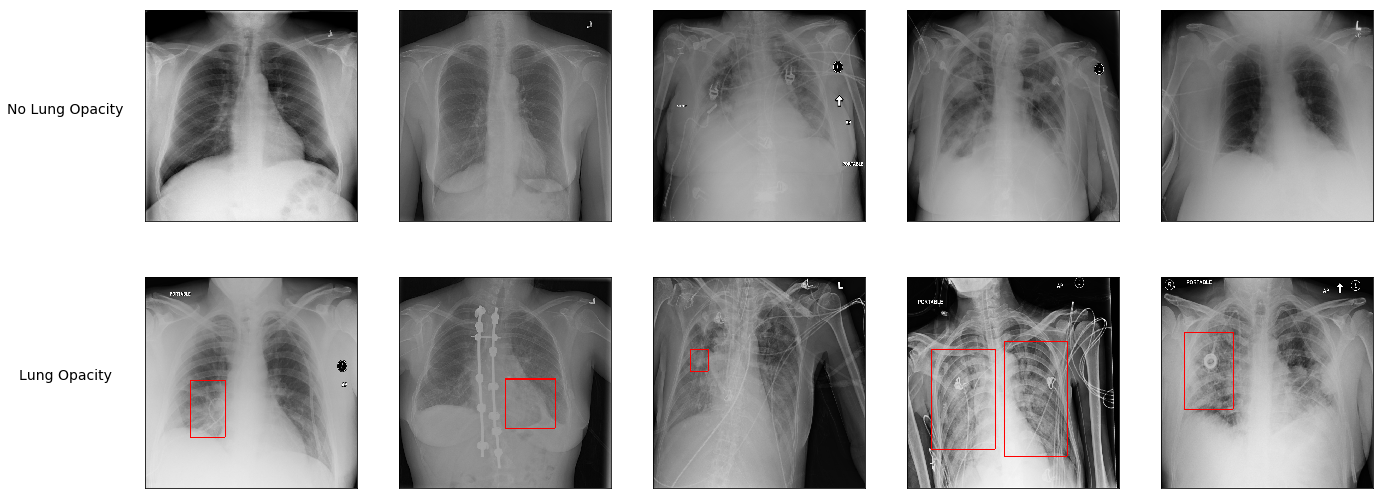

In [0]:
def overlay_boxes(im, boxes, rgb, stroke=5):
    for box in boxes:
        box = [int(b) for b in box]

        x1, y1, width, height = box
        y2 = y1 + height
        x2 = x1 + width

        im[y1:y1 + stroke, x1:x2] = rgb
        im[y2:y2 + stroke, x1:x2] = rgb
        im[y1:y2, x1:x1 + stroke] = rgb
        im[y1:y2, x2:x2 + stroke] = rgb
    return im

cols = 5
fig, ax = plt.subplots(2, cols, figsize=(22, 9))
length = len(train_raw_data_loader)
j_false = 0
j_true = 0
for idx in random.sample(range(length), length):
    img_path, target, boxes = train_raw_data_loader[idx]
    img = load_dcm_img(img_path)
    if target == 0.0 and j_false < cols:
        i = 0
        j = j_false
        j_false += 1
    elif target == 1.0 and j_true < cols:
        i = 1
        j = j_true
        j_true += 1
        # put on bounding boxes
        img = overlay_boxes(img, boxes, rgb=(255, 0, 0))
    elif j_false == cols and j_true == cols:
        break
    else:
        continue

    ax[i, j].imshow(img.astype('uint8'))
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])
ax[0, 0].set_ylabel('No Lung Opacity', fontsize=14, rotation=0, labelpad=80)
ax[1, 0].set_ylabel('Lung Opacity', fontsize=14, rotation=0, labelpad=80)

## Training: Mask RCNN

這裡我們使用Mask R-CNN來做物件偵測，Mask R-CNN是屬於R-CNN體系，R-CNN全名為Regions with CNN，是一種Object Detection的技術架構。我們知道這幾年CNN大放異彩，使用CNN來做Image Classification可以得到相當高的精準度，我們想要將這樣的優勢套用到Object Detection，最簡單的方法是使用Sliding Window掃過圖片，並對這些Siding Window做Image Classification，但是這個作法有個明顯的缺點就是大計算量、速度慢。

於是R-CNN在2014年由Ross Girshick, Jeff Donahue, Trevor Darrell和Jitendra Malik所提出 [[Paper](https://arxiv.org/pdf/1311.2524.pdf)]，與其用 Sliding Window 的方式掃過一輪，RCNN 的作法是預先由一些Region Proposal的方法選出約 2000 個可能的區域，再將這 2000 區域個別去經過CNN產生feature map，再用SVM對這些features來判定是是否為物體或者背景，最後再經由一個線性回歸模型來校正 Bounding Box 位置，如此一來可以大幅的減少計算量。不過仍然有一些問題，第一，這個方法仍然需要計算2000次的CNN，還是太慢，第二，過程步驟太多，稍嫌繁瑣。

RCNN的其中一個作者Ross Girshick在2015年提出了改良版Fast R-CNN [[paper](https://arxiv.org/pdf/1504.08083.pdf)]，著力點在於上述的2000個候選區域其實是有彼此重疊的，因此造成了重複計算，Fast R-CNN 採用了 RoIPooling (Region of Interest Pooling) 來避免重複計算。詳細如下：將整張圖片放下去CNN產生feature map，然後使用RoIPooling將候選區域所囊括的部分抽出，最後送到Fully Connected Layers + Softmax做分類。所以Fast RCNN優點是 1)只需要作一次CNN，省時間 2)單一網路簡化流程。

在2015年，Shaoqing Ren, Kaiming He, Ross Girshick 和 Jian Sun 提出了 Faster R-CNN[[paper](https://arxiv.org/pdf/1506.01497.pdf)]，在這一篇當中引入了Region Proposal Network (RPN)，RPN的核心思想是使用Conv Net直接取代Region Proposal產生候選區域，RPN可以自動學習並預測Bounding Box及其出現機率，雖然這些 Bounding Box 不見得精確，但是透過類似於 Fast R-CNN 的 RoIPooling， 一樣可以很快的對每個區域分類，並找到最精確的 Bounding Box 座標。

在2018年，Kaiming He, Georgia Gkioxari, Piotr Dolla ́r 和 Ross Girshick 提出了 Mask R-CNN [[paper](https://arxiv.org/pdf/1703.06870.pdf)]，在這篇當中引入了Fully Convolutional Network (FCN) for Image Segmentation，此方法使得我們不只可以得到Bounding Box而已，還可以產生Mask將物件給標示出來。

做個總結，R-CNN被提出，使用Region Proposal的方法來挑選區域，避免需要掃過整張圖片，大大的減少CNN的計算量。Fast R-CNN更是直接引入RoIPooling讓我們只需要做一次CNN，就可以評估多個預選區域。Faster R-CNN則是讓我們連候選區域都不需要在一開始給，它採用Region Proposal Network (RPN) 讓神經網路自動學習並預測Bounding Box。Mask R-CNN 建基這些的基礎上，引入Fully Convolutional Network (FCN) 讓我們在產生Bounding Box的時候，可以同時產生Mask將物件給標示出來。

### 前置作業

重新改寫Mask RCNN的`utils.Dataset`，使其符合我們的狀況。

In [0]:
class DetectorDataset(utils.Dataset):

    def __init__(self, train_raw_data_loader, width, height):
        super().__init__(self)
        
        self._width = width
        self._height = height

        self.add_class('lung_opacity', 1, 'Lung Opacity')
        
        for i, (img_path, target, boxes) in enumerate(train_raw_data_loader):
            self.add_image('lung_opacity', image_id=i, path=img_path, target=target, boxes=boxes)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        img = load_dcm_img(info['path'])
        return img

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        boxes = info['boxes']
        count = len(boxes)
        if len(boxes) == 0 and info['target'] == 0.0:
            mask = np.zeros((self._height, self._width, 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((self._height, self._width, count), dtype=np.uint8)
            class_ids = np.ones((count,), dtype=np.int32)
            for i, (x, y, w, h) in enumerate(boxes):
                mask_instance = mask[:, :, i].copy()
                mask_instance = cv2.rectangle(mask_instance, (int(x), int(y)), (int(x+w), int(y+h)), (255, 255, 255), -1)
                mask[:, :, i] = mask_instance
        return mask.astype(np.bool), class_ids.astype(np.int32)

切分出validation的dataset

In [0]:
valid_ratio = 0.2
train_count = int(len(train_raw_data_loader) * (1 - valid_ratio))

train_dataset = DetectorDataset(train_raw_data_loader[:train_count], 1024, 1024)
train_dataset.prepare()
valid_dataset = DetectorDataset(train_raw_data_loader[train_count:], 1024, 1024)
valid_dataset.prepare()

重新改寫Mask RCNN的`Config`，使其符合我們的狀況。

In [0]:
class DetectorConfig(Config):
    # Give the configuration a recognizable name  
    NAME = 'lung_opacity'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 lung_opacity classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.78  ## match target distribution
    DETECTION_NMS_THRESHOLD = 0.01

    STEPS_PER_EPOCH = 200

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.78
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

開始training

In [0]:
model = modellib.MaskRCNN(mode='training', model_dir=MODEL_DIR, config=config)
model.load_weights(model.get_imagenet_weights(), by_name=True)
model.train(train_dataset, valid_dataset,
            learning_rate=0.003,
            epochs=18,
            layers='all')
history = model.keras_model.history.history

94658560/94653016 [==============================] - 2s 0us/step

Starting at epoch 0. LR=0.003

Checkpoint Path: /kaggle/model/lung_opacity20191013T0529/mask_rcnn_lung_opacity_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple worker

Epoch 1/18
200/200 [==============================] - 554s 3s/step - loss: 1.9163 - rpn_class_loss: 0.0790 - rpn_bbox_loss: 0.5552 - mrcnn_class_loss: 0.2164 - mrcnn_bbox_loss: 0.5642 - mrcnn_mask_loss: 0.5015 - val_loss: 1.6491 - val_rpn_class_loss: 0.0241 - val_rpn_bbox_loss: 0.4526 - val_mrcnn_class_loss: 0.1970 - val_mrcnn_bbox_loss: 0.5362 - val_mrcnn_mask_loss: 0.4391
Epoch 2/18
200/200 [==============================] - 306s 2s/step - loss: 1.5961 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.4524 - mrcnn_class_loss: 0.2033 - mrcnn_bbox_loss: 0.4927 - mrcnn_mask_loss: 0.4263 - val_loss: 1.5648 - val_rpn_class_loss: 0.0172 - val_rpn_bbox_loss: 0.4412 - val_mrcnn_class_loss: 0.2111 - val_mrcnn_bbox_loss: 0.4899 - val_mrcnn_mask_loss: 0.4054
Epoch 3/18
200/200 [==============================] - 418s 2s/step - loss: 1.5204 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4286 - mrcnn_class_loss: 0.1962 - mrcnn_bbox_loss: 0.4659 - mrcnn_mask_loss: 0.4131 - val_loss: 1.5054 - val_rpn_class_l

## Evaluation

使用最好的結果來做Evaluation

In [0]:
def get_weight_path(model, epoch):
    # select trained model 
    dir_names = next(os.walk(model.model_dir))[1]
    key = model.config.NAME.lower()
    dir_names = filter(lambda f: f.startswith(key), dir_names)
    dir_names = sorted(dir_names)

    if not dir_names:
        import errno
        raise FileNotFoundError(
            errno.ENOENT,
            "Could not find model directory under {}".format(self.model_dir))

    last_dir_name = dir_names[-1]
    path_last_dir = os.path.join(model.model_dir, last_dir_name)

    checkpoints = next(os.walk(path_last_dir))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))

    checkpoint = os.path.join(path_last_dir, checkpoints[epoch])
    return checkpoint

In [0]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1


inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=MODEL_DIR)


best_epoch = np.argmin(history['val_loss'])
model_path = get_weight_path(model, best_epoch)
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /kaggle/model/lung_opacity20191013T0529/mask_rcnn_lung_opacity_0017.h5
Re-starting from epoch 17


將Evalation全部跑一遍，並且存下來

In [0]:
def get_result(dataset, model):
    result = {}
    for image_id in tqdm(dataset.image_ids, mininterval=5):
        original_image, image_meta, gt_class_id, gt_bbox, gt_mask = \
                modellib.load_image_gt(dataset, inference_config, 
                                       image_id, use_mini_mask=False)
        result[image_id] = model.detect([original_image])[0]
        result[image_id]['gt_class_id'] = gt_class_id
        result[image_id]['gt_bbox'] = gt_bbox
        result[image_id]['gt_mask'] = gt_mask
    return result

In [0]:
valid_result = get_result(valid_dataset, model)

100%|██████████| 5337/5337 [09:12<00:00,  9.66it/s]


In [0]:
train_result = get_result(train_dataset, model)

100%|██████████| 21347/21347 [36:43<00:00,  9.69it/s]


### Model整體健檢

IoU是判定Bounding Box預測的好或不好的重要指標，IoU全名是Intersection-over-union，其計算方式是(預測區域和實際區域的交集)/(預測區域和實際區域的聯集)。

單一一對IoU計算不成問題，如果一張圖片中有多個Ground True (GT)區域，或是一張圖片有多個預測的區域，該怎麼計算其中一個預測區域的IoU便是個問題，這裡我採用的方法是先讓Confidence Score高的區域先選走IoU最高的GT，此種策略有助於最大化AUC和mAP，也就可以看到model的最大能耐。

選定 `IoU_Threshold＝0.5` 後，我們就可以判定這些預測區域是True Positive還是False Positive了，如果 `IoU >= IoU_Threshold` 則是True Positive，相反的 `IoU < IoU_Threshold` 則是False Positive，再搭配其Confidence Score就可以計算出AUC和mAP來了解Model整體的狀況。

這裡的Mean Average Precision (mAP) 是採用在object detection中常見的11-point interpolated AP。

In [0]:
def get_iou(rec1, rec2):
    def compute_intersection(rec1, rec2):
        left_line = max(rec1[1], rec2[1])
        right_line = min(rec1[3], rec2[3])
        top_line = max(rec1[0], rec2[0])
        bottom_line = min(rec1[2], rec2[2])

        if left_line >= right_line or top_line >= bottom_line:
            return 0
        else:
            return (right_line - left_line) * (bottom_line - top_line)
    
    def compute_area(rec):
        return (rec[3] - rec[1]) * (rec[2] - rec[0])
    
    intersection = compute_intersection(rec1, rec2)
    union = compute_area(rec1) + compute_area(rec2) - intersection
    iou = intersection / union
    return iou

def get_confusion_matrix_from_single_image(result, iou_threshold=0.5):
    gt_bboxes = list(result['gt_bbox'])
    pred_bboxes = list(result['rois'])
    pred_scores = list(result['scores'])
    pred_pairs = sorted(zip(pred_scores, pred_bboxes), reverse=True, key=lambda x: x[0])
    labels = [0. for _ in range(len(pred_pairs))]  # 0 means FP
    for i, (score, pred_bbox) in enumerate(pred_pairs):
        max_iou = -1.0
        argmax = -1
        for j in range(len(gt_bboxes)):
            gt_bbox = gt_bboxes[j]
            iou = get_iou(pred_bbox, gt_bbox)
            if iou > max_iou:
                max_iou = iou
                argmax = j
        if argmax >= 0 and max_iou >= iou_threshold:
            gt_bboxes.pop(argmax)
            labels[i] = 1.  # 1 means TP
    return list(zip(pred_scores, labels))

In [0]:
valid_pred_label_pairs = []
for result in valid_result.values():
    valid_pred_label_pairs += get_confusion_matrix_from_single_image(result)
valid_pred_label_pairs = sorted(valid_pred_label_pairs, reverse=True)
all_scores, all_labels = zip(*valid_pred_label_pairs)

In [0]:
def get_interpolated_ap(precision, recall):
    # smooth out the zigzag precision-recall curve
    smoothed_precision = []
    accumulator = 0.0
    for p in list(precision):
        if p > accumulator:
            accumulator = p
        smoothed_precision.append(accumulator)

    # calculate 11-point interpolated AP
    interp = scipy.interpolate.interp1d(recall, smoothed_precision)
    interpolated_precision = interp([i * 0.1 for i in range(11)])
    interpolated_ap = np.mean(interpolated_precision)
    return interpolated_ap

In [0]:
fpr, tpr, roc_thresholds = roc_curve(all_labels, all_scores, pos_label=1)
roc_auc = auc(fpr, tpr)
precision, recall, pr_thresholds = precision_recall_curve(all_labels, all_scores, pos_label=1)
interpolated_ap = get_interpolated_ap(precision, recall)

print('ROC area = ', roc_auc)
print('mAP = ', interpolated_ap)

ROC area =  0.789771250747523
mAP =  0.3040168618758825


Text(0, 0.5, 'Threshold')

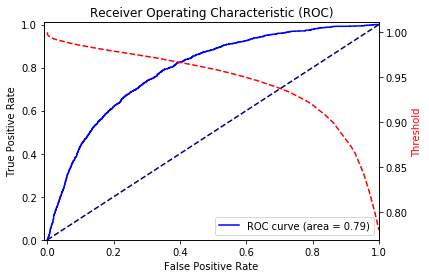

In [0]:
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# adjust upper bound threshold
roc_thresholds[0] = 1.0

ax2 = plt.gca().twinx()
ax2.plot(fpr, roc_thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')

Text(0, 0.5, 'Threshold')

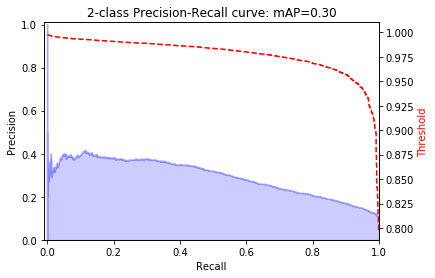

In [0]:
from inspect import signature


step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.title('2-class Precision-Recall curve: mAP={0:0.2f}'.format(
          interpolated_ap))

# add upper bound threshold
extended_thresholds = list(pr_thresholds) + [1.0]

ax2 = plt.gca().twinx()
ax2.plot(recall, extended_thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')

### 找出最佳Confidence Threshold

我們的model還不能使用，還差在決定Confidence Threshold，我在這裡使用Train Dataset來決定這個Confidence Threshold。

計算細節：
* 目標：切一刀，使得整體切錯的數量最少，包含False Positive和False Negative
* 演算法：
    * 從預測為假的角度看各種切法會造成False Negative的數量
    * 從預測為真的角度看各種切法會造成False Positive的數量
    * 相加可以得到各種切法造成False Positive + False Negative的數量
    * 選出最小錯誤的那一刀
* 選出最小錯誤的那一刀
* 考慮到原始資料的不平衡，GT為真的樣品數量較少，應該要給予較高的權重，故引入權重來決定那一刀要切哪裡

In [0]:
def find_best_score_threshold(score_label_pairs, true_sample_ratio=0.5):
    pairs = sorted(list(score_label_pairs))
    mistake = [0 for _ in range(len(pairs)+1)]

    acc = 0
    for i, (score, label) in enumerate(pairs):
        if label == 1:
            acc += 1 - true_sample_ratio
        mistake[1 + i] += acc

    acc = 0
    for i, (score, label) in enumerate(reversed(pairs)):
        if label == 0:
            acc += true_sample_ratio
        mistake[-i - 2] += acc

    idx = np.argmin(mistake)
    if idx >= len(score_label_pairs):
        return None
    score_threshold = score_label_pairs[idx][0]
    print('sum of weighted mistake: ', mistake[idx])
    return score_threshold


# Get best score threshold
train_pred_label_pairs = []
for result in train_result.values():
    train_pred_label_pairs += get_confusion_matrix_from_single_image(result)

true_sample_ratio = target_dict[1] / sum(target_dict.values())
score_threshold = find_best_score_threshold(train_pred_label_pairs, true_sample_ratio=true_sample_ratio)
print(score_threshold)

sum of weighted mistake:  3062.9746664668364
0.97371507


有了 `score_threshold` 就可以正式的決定我們的Model

In [0]:
# Refine valid result with the score threshold
refined_valid_result = {}
for img_id, r in valid_result.items():
    selected = r['scores'] >= score_threshold
    info = {}
    info.update(r)
    info['rois'] = r['rois'][selected, :]
    info['class_ids'] = r['class_ids'][selected]
    info['scores'] = r['scores'][selected]
    info['masks'] = r['masks'][:, :, selected]
    refined_valid_result[img_id] = info

### 結果展示

In [0]:
def display_differences(ax, original_image,
                        gt_bbox, gt_class_id, gt_mask,
                        pred_bbox, pred_class_id, pred_mask,
                        pred_score, class_names):
    count_gt_bbox = gt_bbox.shape[0]
    if count_gt_bbox > 0:
        gt_color = (1, 0, 0, 0.5)
        visualize.display_instances(
            original_image, gt_bbox, gt_mask, gt_class_id, 
            class_names, ax=ax,
            colors=[gt_color] * count_gt_bbox, captions=[''] * count_gt_bbox,
            show_mask=False)


    def get_max_iou(pred_bbox, gt_bboxes):
        max_iou = 0.0
        for i in range(len(gt_bboxes)):
            gt_bbox = gt_bboxes[i, :]
            iou = get_iou(pred_bbox, gt_bbox)
            if iou > max_iou:
                max_iou = iou
        return max_iou

    
    count_pred_bbox = pred_bbox.shape[0]
    if count_pred_bbox > 0:
        pred_color = (0, 1, 0, 0.5)
        captions = []
        for i in range(count_pred_bbox):
            score = pred_score[i]
            max_iou = get_max_iou(pred_bbox[i, :], gt_bbox)
            captions.append('score = {:.3f} / iou = {:.3f}'.format(score, max_iou))

        visualize.display_instances(
            original_image, pred_bbox, pred_mask, pred_class_id, 
            class_names, ax=ax,
            colors=[pred_color] * count_pred_bbox, captions=captions)

    if count_gt_bbox == 0 and count_pred_bbox == 0:
        ax.imshow(original_image.astype('uint8'))

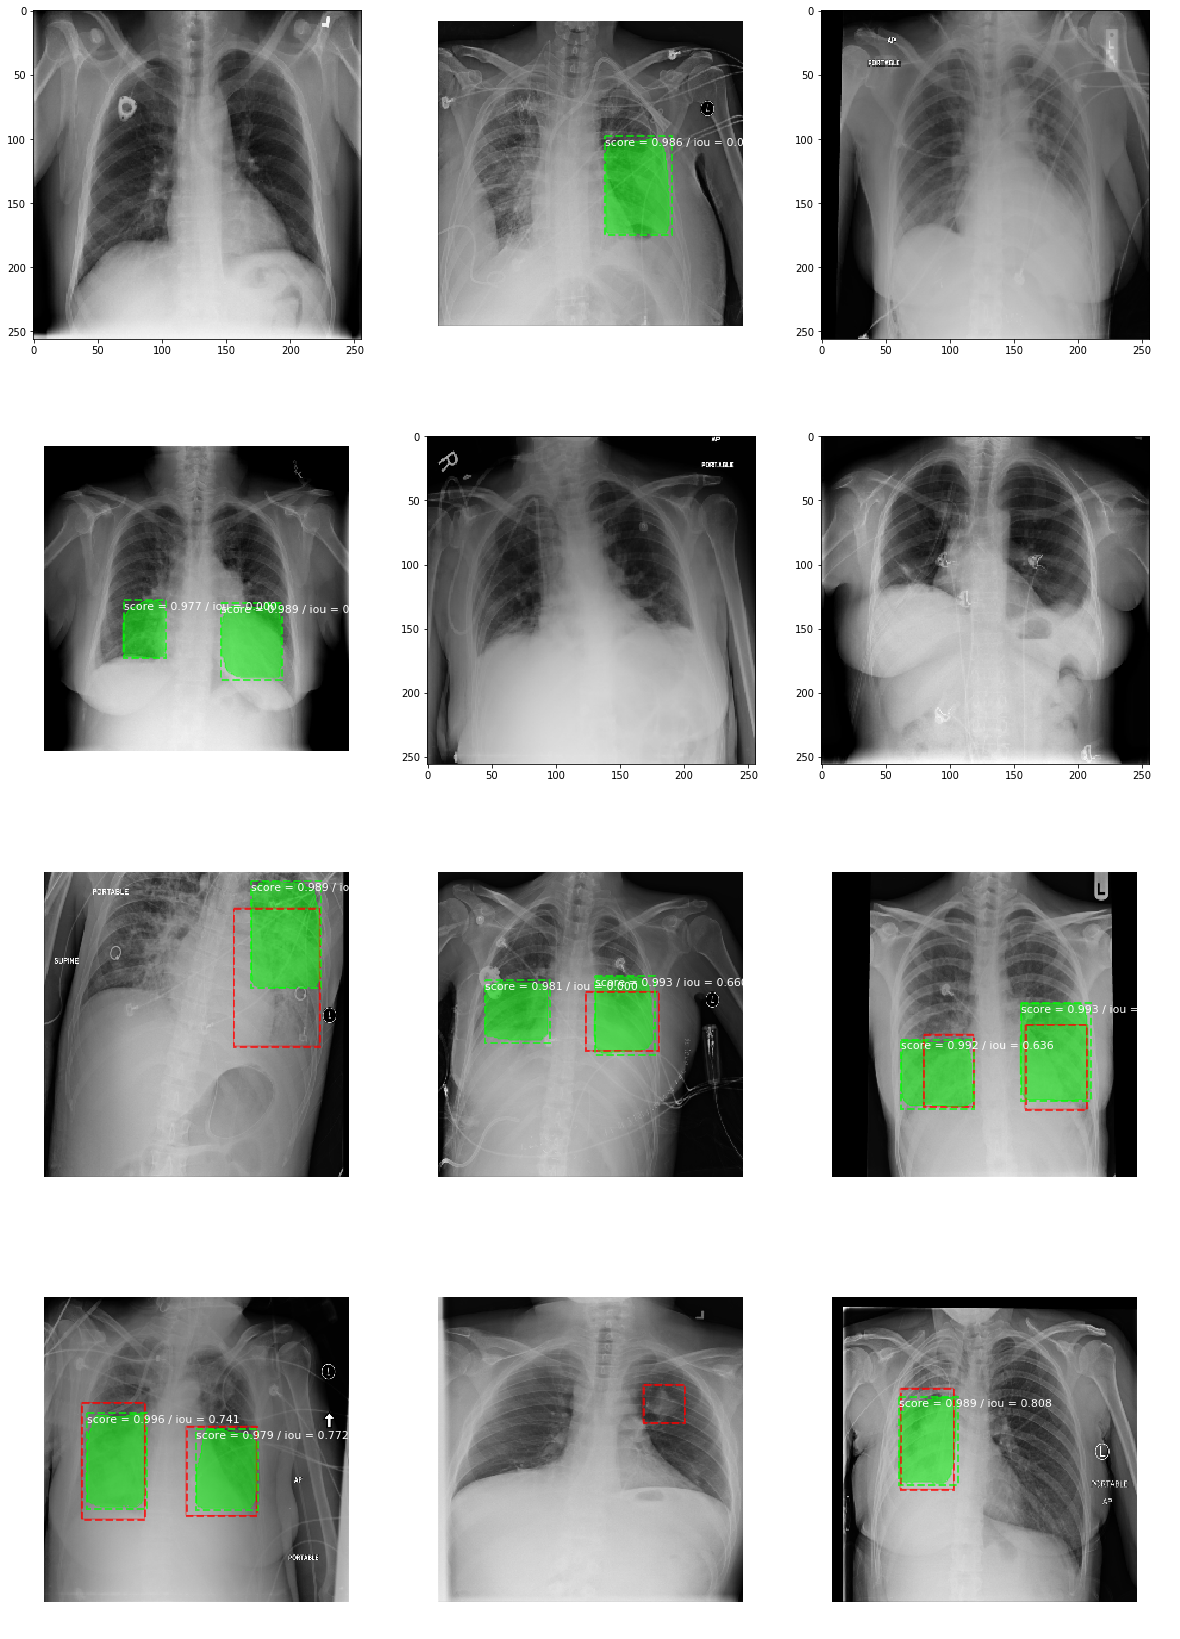

In [0]:
fig, ax = plt.subplots(4, 3, figsize=(20, 30))
for i in range(12):
    row = i // 3
    col = i % 3
    while True:
        image_id = random.choice(list(refined_valid_result.keys()))
        result = refined_valid_result[image_id]
        gt_bbox = result['gt_bbox']

        if 0 <= row <= 1 and gt_bbox.shape[0] > 0:
            continue
        elif 2 <= row <=3 and gt_bbox.shape[0] == 0:
            continue
        else:
            break

    original_image, _, _, _, _ = \
        modellib.load_image_gt(valid_dataset, inference_config, 
                               image_id, use_mini_mask=False)
    gt_bbox = result['gt_bbox']
    gt_class_id = result['gt_class_id']
    gt_mask = result['gt_mask']
    pred_bbox = result['rois']
    pred_class_id = result['class_ids']
    pred_score = result['scores']
    pred_mask = result['masks']
    class_names = train_dataset.class_names

    display_differences(ax[i // 3][i % 3], original_image,
                        gt_bbox, gt_class_id, gt_mask,
                        pred_bbox, pred_class_id, pred_mask,
                        pred_score, class_names)

上圖中，紅色虛線所框的區域是Ground True (GT)，綠色虛線則是預測的Bounding Box，綠色實心則是預測的Mask，每個預測的Bounding Box都有標注Confidence Score和IoU，其IoU的計算也是採用「先讓Confidence Score高的區域先選走IoU最高的GT」策略。

## Reference

* https://medium.com/cubo-ai/%E7%89%A9%E9%AB%94%E5%81%B5%E6%B8%AC-object-detection-740096ec4540
* https://github.com/rafaelpadilla/Object-Detection-Metrics/blob/master/README.md
* https://towardsdatascience.com/breaking-down-mean-average-precision-map-ae462f623a52
